In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More sell CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  lab

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  la

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


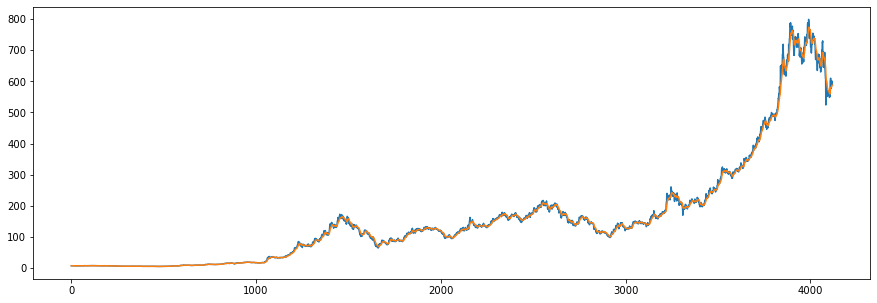

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


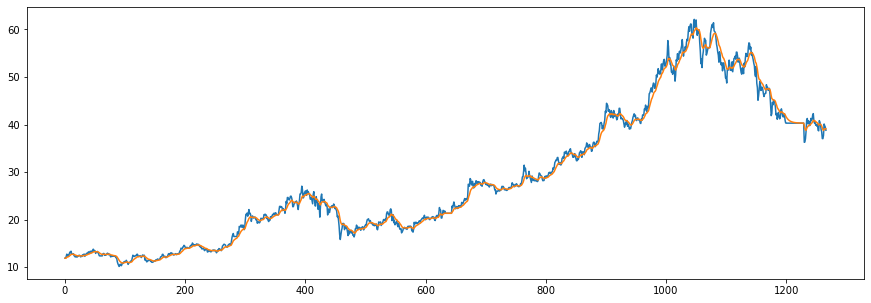

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


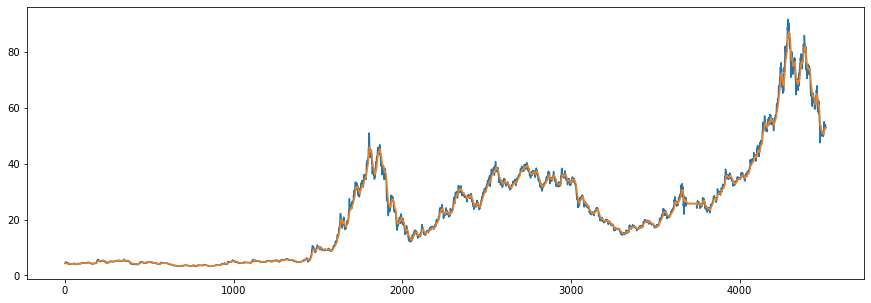

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


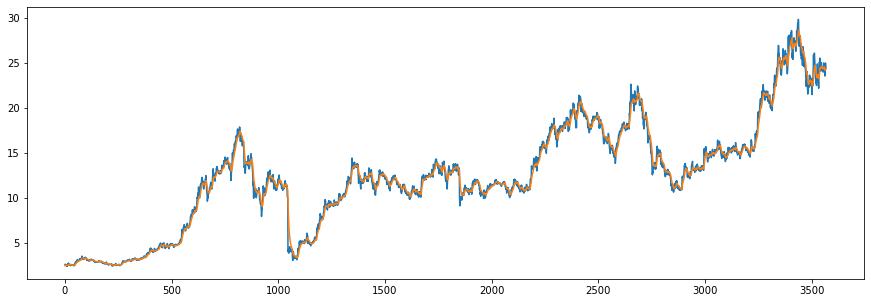

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


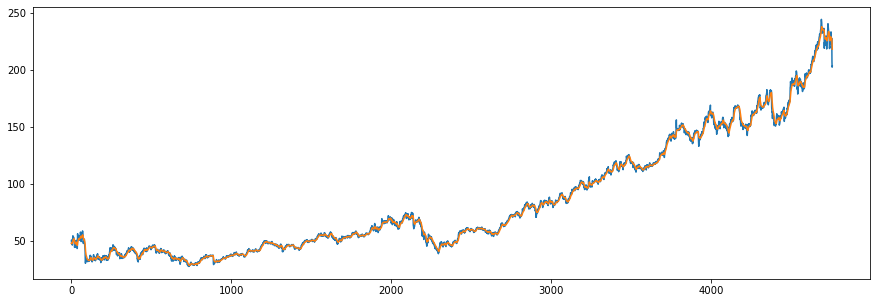

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


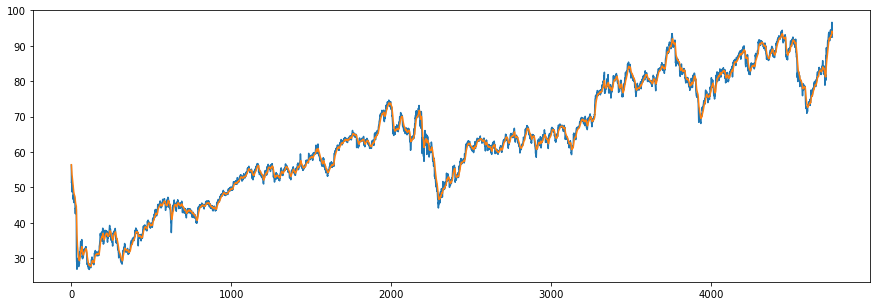

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


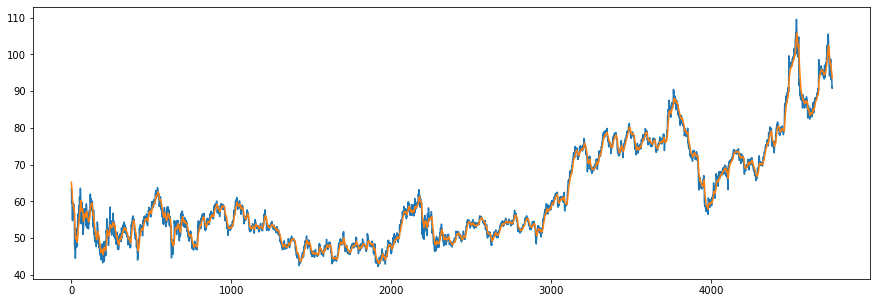

In [10]:
sequential_data = []
labels = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(27645, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1252]
class_1 = class_1[0:939]
class_2 = class_2[0:939]

class_0_labels = class_0_labels[0:1252]
class_1_labels = class_1_labels[0:939]
class_2_labels = class_2_labels[0:939]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(3130, 64, 64, 1)


Counter({0.0: 1252, 1.0: 939, 2.0: 939})

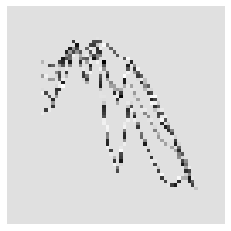

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.8330006653359947, 1: 1.1114070128717266, 2: 1.1114070128717266}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/20 [>.............................] - ETA: 0s - loss: 0.4423 - accuracy: 0.3594 - mse: 5.9827 - weighted_accuracy: 0.3804 - weighted_mse: 5.9024WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20/20 [==============================] - 1s 32ms/step - loss: 0.2473 - accuracy: 0.3391 - mse: 1.8031 - weighted_accuracy: 0.3417 - weighted_mse: 1.8002 - val_loss: 0.2057 - val_accuracy: 0.3035 - val_mse: 0.8380 - val_weighted_accuracy: 0.3035 - val_weighted_mse: 0.8380
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.2055 - accuracy: 0.3131 - mse: 1.1781 - weighted_accuracy: 0.3222 - weighted_mse: 1.1736 - val_loss: 0.1984

Share price: $0.3795228821811101
Shares owned at the moment: 0
Cash capital at the moment: $3407.162100524388


Share price: $0.5155695917265091
Shares owned at the moment: 6590
Cash capital at the moment: $0.21508112062929285


Price increase from previously bought: -3.00899053781023%
Share price: $0.5014313059122446
Shares owned at the moment: 0
Cash capital at the moment: $3295.560198240926


Share price: $0.4426776877814631
Shares owned at the moment: 7424
Cash capital at the moment: $0.08333647759764062


Price increase from previously bought: 32.85727275509718%
Share price: $0.5897468592152508
Shares owned at the moment: 0
Cash capital at the moment: $4366.3237474138805


Share price: $0.8081499037700826
Shares owned at the moment: 5388
Cash capital at the moment: $0.037708776513682096


Price increase from previously bought: -1.4974242762739953%
Share price: $0.7982376042173809
Shares owned at the moment: 0
Cash capital at the moment: $4289.114433718072


Share price: $0.8352190

7/7 [==============================] - 0s 2ms/step - loss: 0.1993 - accuracy: 0.0676 - mse: 0.9425 - weighted_accuracy: 0.0676 - weighted_mse: 0.9425
Test loss: 0.19931675493717194
Test accuracy: 0.06763284653425217


number of predictions: 207
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 124
actual holds but predicted sell: 62
actual predicted holds: 0
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 5.970149253731344%
Percentage holds correct: 0%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 51.798561151079134%
Percentage high sells correct: 55.223880597014926%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.06551658052992314
Shares owned at the moment: 1522
Cash capital at the moment: $0.009544785648984089


Price increase from previously

7/7 [==============================] - 0s 5ms/step - loss: 0.1996 - accuracy: 0.0596 - mse: 0.9470 - weighted_accuracy: 0.0596 - weighted_mse: 0.9470
Test loss: 0.19960100948810577
Test accuracy: 0.059633027762174606


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 135
actual holds but predicted sell: 67
actual predicted holds: 0
Percentage buys correct: 4.861111111111111%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 0%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 38.35616438356164%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from previously boug

Price increase from previously bought: -15.928886861834146%
Share price: $0.3591998369557057
Shares owned at the moment: 0
Cash capital at the moment: $111.09548051923296


Share price: $0.30277799553193563
Shares owned at the moment: 365
Cash capital at the moment: $0.27759873706128246


Price increase from previously bought: 41.08277047520876%
Share price: $0.4283422953430944
Shares owned at the moment: 0
Cash capital at the moment: $156.1925879583401


Share price: $0.572577014010289
Shares owned at the moment: 272
Cash capital at the moment: $0.023352541061797183


Price increase from previously bought: 1.0836834760617586%
Share price: $0.5803735868242181
Shares owned at the moment: 0
Cash capital at the moment: $157.4508487143046


Share price: $0.5957613617579736
Shares owned at the moment: 263
Cash capital at the moment: $0.33472616706609415


Price increase from previously bought: 10.028922920168014%
Share price: $0.6573124614929953
Shares owned at the moment: 0
Cash capital at

7/7 [==============================] - 0s 2ms/step - loss: 0.1993 - accuracy: 0.0594 - mse: 0.9484 - weighted_accuracy: 0.0594 - weighted_mse: 0.9484
Test loss: 0.19930583238601685
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 132
actual holds but predicted sell: 67
actual predicted holds: 0
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.63013698630137%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bough

20/20 [==============================] - 0s 9ms/step - loss: 0.1921 - accuracy: 0.4445 - mse: 1.2075 - weighted_accuracy: 0.4425 - weighted_mse: 1.2064 - val_loss: 0.1868 - val_accuracy: 0.5463 - val_mse: 0.9680 - val_weighted_accuracy: 0.5463 - val_weighted_mse: 0.9680
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1917 - accuracy: 0.4301 - mse: 1.2050 - weighted_accuracy: 0.4277 - weighted_mse: 1.2032 - val_loss: 0.1849 - val_accuracy: 0.5192 - val_mse: 1.0219 - val_weighted_accuracy: 0.5192 - val_weighted_mse: 1.0219
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1904 - accuracy: 0.4421 - mse: 1.2104 - weighted_accuracy: 0.4391 - weighted_mse: 1.2118 - val_loss: 0.1857 - val_accuracy: 0.5447 - val_mse: 0.9692 - val_weighted_accuracy: 0.5447 - val_weighted_mse: 0.9692
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1907 - accuracy: 0.4421 - mse: 1.2255 - weighted_accuracy: 0.4384 - weighted_mse: 1.2256 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.0913 - mse: 1.1435 - weighted_accuracy: 0.0913 - weighted_mse: 1.1435
Test loss: 0.2032599300146103
Test accuracy: 0.09134615212678909


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 59
actual holds but predicted sell: 127
actual predicted holds: 3
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 75.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.470588235294116%
Percentage high sells correct: 49.629629629629626%
Percentage mid holds correct: 50.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previou

7/7 [==============================] - 0s 2ms/step - loss: 0.2044 - accuracy: 0.0673 - mse: 1.1647 - weighted_accuracy: 0.0673 - weighted_mse: 1.1647
Test loss: 0.2044338434934616
Test accuracy: 0.06730769574642181


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 79
actual holds but predicted sell: 112
actual predicted holds: 2
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 5.042016806722689%
Percentage holds correct: 66.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 52.325581395348834%
Percentage high sells correct: 51.69491525423729%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.0913 - mse: 1.1514 - weighted_accuracy: 0.0913 - weighted_mse: 1.1514
Test loss: 0.20067092776298523
Test accuracy: 0.09132420271635056


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 87
actual predicted holds: 5
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 9.278350515463918%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.58620689655172%
Percentage high sells correct: 48.45360824742268%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from previously

3           5.320149  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2023 - accuracy: 0.0685 - mse: 1.1564 - weighted_accuracy: 0.0685 - weighted_mse: 1.1564
Test loss: 0.20232872664928436
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 93
actual holds but predicted sell: 104
actual predicted holds: 2
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 6.140350877192983%
Percentage holds correct: 66.66666666666667%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 49.504950495049506%
Percentage high sells correct: 44.73684210526316%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital a

20/20 [==============================] - 0s 14ms/step - loss: 0.1819 - accuracy: 0.5236 - mse: 1.3009 - weighted_accuracy: 0.5113 - weighted_mse: 1.3047 - val_loss: 0.1757 - val_accuracy: 0.5719 - val_mse: 1.0021 - val_weighted_accuracy: 0.5719 - val_weighted_mse: 1.0021
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1799 - accuracy: 0.5423 - mse: 1.2766 - weighted_accuracy: 0.5308 - weighted_mse: 1.2815 - val_loss: 0.1733 - val_accuracy: 0.5767 - val_mse: 1.0330 - val_weighted_accuracy: 0.5767 - val_weighted_mse: 1.0330
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.5363 - mse: 1.3006 - weighted_accuracy: 0.5205 - weighted_mse: 1.3039 - val_loss: 0.1727 - val_accuracy: 0.5783 - val_mse: 1.0653 - val_weighted_accuracy: 0.5783 - val_weighted_mse: 1.0653
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.5447 - mse: 1.2995 - weighted_accuracy: 0.5317 - weighted_mse: 1.3032 

7/7 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.1010 - mse: 1.2299 - weighted_accuracy: 0.1010 - weighted_mse: 1.2299
Test loss: 0.21088320016860962
Test accuracy: 0.10096153616905212


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 58
actual holds but predicted sell: 126
actual predicted holds: 5
Percentage buys correct: 11.940298507462687%
Percentage sells correct: 5.925925925925926%
Percentage holds correct: 83.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.73134328358209%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 50.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.0913 - mse: 1.2686 - weighted_accuracy: 0.0913 - weighted_mse: 1.2686
Test loss: 0.21467740833759308
Test accuracy: 0.09134615212678909


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 69
actual holds but predicted sell: 117
actual predicted holds: 7
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 4.838709677419355%
Percentage holds correct: 87.5%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 54.47154471544715%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.1324 - mse: 1.2236 - weighted_accuracy: 0.1324 - weighted_mse: 1.2236
Test loss: 0.20710980892181396
Test accuracy: 0.13242009282112122


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 98
actual holds but predicted sell: 89
actual predicted holds: 14
Percentage buys correct: 5.660377358490566%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 47.474747474747474%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase f

7/7 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.1142 - mse: 1.2367 - weighted_accuracy: 0.1142 - weighted_mse: 1.2367
Test loss: 0.21039371192455292
Test accuracy: 0.11415524780750275


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 107
actual predicted holds: 12
Percentage buys correct: 6.741573033707865%
Percentage sells correct: 6.0344827586206895%
Percentage holds correct: 85.71428571428571%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 45.689655172413794%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


P

20/20 [==============================] - 0s 14ms/step - loss: 0.1687 - accuracy: 0.5799 - mse: 1.3999 - weighted_accuracy: 0.5634 - weighted_mse: 1.4037 - val_loss: 0.1667 - val_accuracy: 0.5927 - val_mse: 1.1580 - val_weighted_accuracy: 0.5927 - val_weighted_mse: 1.1580
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1686 - accuracy: 0.5895 - mse: 1.3832 - weighted_accuracy: 0.5746 - weighted_mse: 1.3894 - val_loss: 0.1674 - val_accuracy: 0.5847 - val_mse: 1.2057 - val_weighted_accuracy: 0.5847 - val_weighted_mse: 1.2057
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1672 - accuracy: 0.5942 - mse: 1.4307 - weighted_accuracy: 0.5764 - weighted_mse: 1.4340 - val_loss: 0.1672 - val_accuracy: 0.5911 - val_mse: 1.1680 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 1.1680
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1669 - accuracy: 0.5958 - mse: 1.3970 - weighted_accuracy: 0.5793 - weighted_mse: 1.3999 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.1394 - mse: 1.3632 - weighted_accuracy: 0.1394 - weighted_mse: 1.3632
Test loss: 0.20947274565696716
Test accuracy: 0.13942307233810425


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 122
actual predicted holds: 13
Percentage buys correct: 12.698412698412698%
Percentage sells correct: 6.106870229007634%
Percentage holds correct: 92.85714285714286%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.45161290322581%
Percentage high sells correct: 48.091603053435115%
Percentage mid holds correct: 57.142857142857146%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916



7/7 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.1250 - mse: 1.4146 - weighted_accuracy: 0.1250 - weighted_mse: 1.4146
Test loss: 0.21518881618976593
Test accuracy: 0.125


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 68
actual holds but predicted sell: 110
actual predicted holds: 15
Percentage buys correct: 8.0%
Percentage sells correct: 4.310344827586207%
Percentage holds correct: 88.23529411764706%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.666666666666664%
Percentage high sells correct: 54.310344827586206%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: 17.

2        9380.979094  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.1781 - mse: 1.3725 - weighted_accuracy: 0.1781 - weighted_mse: 1.3725
Test loss: 0.20597264170646667
Test accuracy: 0.1780821979045868


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 91
actual holds but predicted sell: 86
actual predicted holds: 24
Percentage buys correct: 5.154639175257732%
Percentage sells correct: 10.309278350515465%
Percentage holds correct: 96.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.083333333333336%
Percentage high sells correct: 46.391752577319586%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862

7/7 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.1689 - mse: 1.3869 - weighted_accuracy: 0.1689 - weighted_mse: 1.3869
Test loss: 0.20953382551670074
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 95
actual predicted holds: 24
Percentage buys correct: 6.741573033707865%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 47.57281553398058%
Percentage mid holds correct: 81.48148148148148%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price

20/20 [==============================] - 0s 14ms/step - loss: 0.1586 - accuracy: 0.6386 - mse: 1.4735 - weighted_accuracy: 0.6238 - weighted_mse: 1.4772 - val_loss: 0.1657 - val_accuracy: 0.6022 - val_mse: 1.3097 - val_weighted_accuracy: 0.6022 - val_weighted_mse: 1.3097
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1582 - accuracy: 0.6322 - mse: 1.4772 - weighted_accuracy: 0.6186 - weighted_mse: 1.4778 - val_loss: 0.1652 - val_accuracy: 0.5974 - val_mse: 1.3400 - val_weighted_accuracy: 0.5974 - val_weighted_mse: 1.3400
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1562 - accuracy: 0.6538 - mse: 1.5014 - weighted_accuracy: 0.6400 - weighted_mse: 1.5052 - val_loss: 0.1657 - val_accuracy: 0.6022 - val_mse: 1.2912 - val_weighted_accuracy: 0.6022 - val_weighted_mse: 1.2912
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.6458 - mse: 1.5187 - weighted_accuracy: 0.6320 - weighted_mse: 1.5217 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.1587 - mse: 1.4783 - weighted_accuracy: 0.1587 - weighted_mse: 1.4783
Test loss: 0.21787120401859283
Test accuracy: 0.1586538404226303


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 55
actual holds but predicted sell: 116
actual predicted holds: 18
Percentage buys correct: 12.5%
Percentage sells correct: 5.645161290322581%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 49.193548387096776%
Percentage mid holds correct: 65.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 19

7/7 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.1154 - mse: 1.5384 - weighted_accuracy: 0.1154 - weighted_mse: 1.5384
Test loss: 0.22611895203590393
Test accuracy: 0.11538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 109
actual predicted holds: 13
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 86.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.97435897435897%
Percentage high sells correct: 55.26315789473684%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


P

7/7 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.1835 - mse: 1.4635 - weighted_accuracy: 0.1835 - weighted_mse: 1.4635
Test loss: 0.21539950370788574
Test accuracy: 0.1834862381219864


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 95
actual predicted holds: 27
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 93.10344827586206%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 53.48837209302326%
Percentage high sells correct: 46.07843137254902%
Percentage mid holds correct: 89.65517241379311%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.2110 - mse: 1.4221 - weighted_accuracy: 0.2110 - weighted_mse: 1.4221
Test loss: 0.2037576287984848
Test accuracy: 0.2110091745853424


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 90
actual predicted holds: 30
Percentage buys correct: 10.227272727272727%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.86363636363637%
Percentage high sells correct: 49.48453608247423%
Percentage mid holds correct: 90.625%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase fr

3         -65.971313  



RUNNING EPOCHS 100 - 120



Epoch 1/20
20/20 [==============================] - 0s 13ms/step - loss: 0.1488 - accuracy: 0.6617 - mse: 1.5984 - weighted_accuracy: 0.6455 - weighted_mse: 1.5974 - val_loss: 0.1671 - val_accuracy: 0.5863 - val_mse: 1.3881 - val_weighted_accuracy: 0.5863 - val_weighted_mse: 1.3881
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1481 - accuracy: 0.6633 - mse: 1.5724 - weighted_accuracy: 0.6494 - weighted_mse: 1.5730 - val_loss: 0.1668 - val_accuracy: 0.5927 - val_mse: 1.4920 - val_weighted_accuracy: 0.5927 - val_weighted_mse: 1.4920
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1450 - accuracy: 0.6749 - mse: 1.6528 - weighted_accuracy: 0.6613 - weighted_mse: 1.6497 - val_loss: 0.1686 - val_accuracy: 0.5927 - val_mse: 1.3931 - val_weighted_accuracy: 0.5927 - val_weighted_mse: 1.3931
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1454 - accuracy: 0.6769 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2327 - accuracy: 0.2019 - mse: 1.8711 - weighted_accuracy: 0.2019 - weighted_mse: 1.8711
Test loss: 0.2326631247997284
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 45
actual holds but predicted sell: 117
actual predicted holds: 27
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 5.6%
Percentage holds correct: 93.10344827586206%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.407407407407405%
Percentage high sells correct: 47.2%
Percentage mid holds correct: 71.42857142857143%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.2471 - accuracy: 0.1442 - mse: 1.9469 - weighted_accuracy: 0.1442 - weighted_mse: 1.9469
Test loss: 0.2470802664756775
Test accuracy: 0.14423076808452606


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 64
actual holds but predicted sell: 110
actual predicted holds: 19
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 90.47619047619048%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.57142857142857%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.2064 - mse: 1.8254 - weighted_accuracy: 0.2064 - weighted_mse: 1.8254
Test loss: 0.2281210720539093
Test accuracy: 0.20642201602458954


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 63
actual holds but predicted sell: 105
actual predicted holds: 34
Percentage buys correct: 5.970149253731344%
Percentage sells correct: 6.140350877192983%
Percentage holds correct: 91.89189189189189%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 52.23880597014925%
Percentage high sells correct: 45.13274336283186%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.2204 - accuracy: 0.2374 - mse: 1.8126 - weighted_accuracy: 0.2374 - weighted_mse: 1.8126
Test loss: 0.22035163640975952
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 74
actual holds but predicted sell: 88
actual predicted holds: 39
Percentage buys correct: 5.063291139240507%
Percentage sells correct: 9.183673469387756%
Percentage holds correct: 92.85714285714286%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.164556962025316%
Percentage high sells correct: 44.89795918367347%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.2324 - accuracy: 0.2237 - mse: 1.8905 - weighted_accuracy: 0.2237 - weighted_mse: 1.8905
Test loss: 0.23244845867156982
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 98
actual predicted holds: 34
Percentage buys correct: 9.333333333333334%
Percentage sells correct: 7.547169811320755%
Percentage holds correct: 89.47368421052632%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 55.4054054054054%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 81.57894736842105%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Price increase fro

20/20 [==============================] - 0s 14ms/step - loss: 0.1340 - accuracy: 0.7268 - mse: 1.7565 - weighted_accuracy: 0.7143 - weighted_mse: 1.7574 - val_loss: 0.1712 - val_accuracy: 0.5559 - val_mse: 1.6454 - val_weighted_accuracy: 0.5559 - val_weighted_mse: 1.6454
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1323 - accuracy: 0.7268 - mse: 1.8089 - weighted_accuracy: 0.7162 - weighted_mse: 1.8067 - val_loss: 0.1731 - val_accuracy: 0.5799 - val_mse: 1.7383 - val_weighted_accuracy: 0.5799 - val_weighted_mse: 1.7383
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1314 - accuracy: 0.7276 - mse: 1.7735 - weighted_accuracy: 0.7141 - weighted_mse: 1.7688 - val_loss: 0.1721 - val_accuracy: 0.5591 - val_mse: 1.6094 - val_weighted_accuracy: 0.5591 - val_weighted_mse: 1.6094
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1298 - accuracy: 0.7308 - mse: 1.7813 - weighted_accuracy: 0.7204 - weighted_mse: 1.7775 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.1827 - mse: 2.2314 - weighted_accuracy: 0.1827 - weighted_mse: 2.2314
Test loss: 0.27279555797576904
Test accuracy: 0.18269230425357819


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 47
actual holds but predicted sell: 119
actual predicted holds: 23
Percentage buys correct: 14.035087719298245%
Percentage sells correct: 5.511811023622047%
Percentage holds correct: 95.83333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.14035087719298%
Percentage high sells correct: 49.60629921259842%
Percentage mid holds correct: 73.91304347826087%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


P

7/7 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.1250 - mse: 2.3886 - weighted_accuracy: 0.1250 - weighted_mse: 2.3886
Test loss: 0.3014698624610901
Test accuracy: 0.125


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 68
actual holds but predicted sell: 110
actual predicted holds: 15
Percentage buys correct: 6.8493150684931505%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 83.33333333333333%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.16438356164384%
Percentage high sells correct: 52.99145299145299%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.1918 - mse: 2.1906 - weighted_accuracy: 0.1918 - weighted_mse: 2.1906
Test loss: 0.26143020391464233
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 86
actual predicted holds: 28
Percentage buys correct: 4.395604395604396%
Percentage sells correct: 10.309278350515465%
Percentage holds correct: 90.3225806451613%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 46.391752577319586%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


P

7/7 [==============================] - 0s 2ms/step - loss: 0.2792 - accuracy: 0.1963 - mse: 2.3117 - weighted_accuracy: 0.1963 - weighted_mse: 2.3117
Test loss: 0.2792482376098633
Test accuracy: 0.19634702801704407


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 77
actual holds but predicted sell: 96
actual predicted holds: 26
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.11764705882353%
Percentage high sells correct: 50.476190476190474%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.1181 - accuracy: 0.7676 - mse: 1.9590 - weighted_accuracy: 0.7569 - weighted_mse: 1.9512 - val_loss: 0.1812 - val_accuracy: 0.5543 - val_mse: 1.9473 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 1.9473
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1194 - accuracy: 0.7648 - mse: 1.9543 - weighted_accuracy: 0.7574 - weighted_mse: 1.9551 - val_loss: 0.1792 - val_accuracy: 0.5639 - val_mse: 1.8083 - val_weighted_accuracy: 0.5639 - val_weighted_mse: 1.8083
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1172 - accuracy: 0.7688 - mse: 1.9506 - weighted_accuracy: 0.7588 - weighted_mse: 1.9439 - val_loss: 0.1821 - val_accuracy: 0.5623 - val_mse: 1.8993 - val_weighted_accuracy: 0.5623 - val_weighted_mse: 1.8993
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1148 - accuracy: 0.7672 - mse: 2.0202 - weighted_accuracy: 0.7582 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.2958 - accuracy: 0.2019 - mse: 2.3876 - weighted_accuracy: 0.2019 - weighted_mse: 2.3876
Test loss: 0.2957576811313629
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 47
actual holds but predicted sell: 114
actual predicted holds: 28
Percentage buys correct: 12.5%
Percentage sells correct: 5.691056910569106%
Percentage holds correct: 96.55172413793103%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 49.59349593495935%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase 

7/7 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.1394 - mse: 2.6070 - weighted_accuracy: 0.1394 - weighted_mse: 2.6070
Test loss: 0.338596373796463
Test accuracy: 0.13942307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 110
actual predicted holds: 18
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 85.71428571428571%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 0.1881 - mse: 2.3279 - weighted_accuracy: 0.1881 - weighted_mse: 2.3279
Test loss: 0.2918752431869507
Test accuracy: 0.18807339668273926


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 72
actual holds but predicted sell: 101
actual predicted holds: 29
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 7.207207207207207%
Percentage holds correct: 93.54838709677419%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.2100 - mse: 2.3020 - weighted_accuracy: 0.2100 - weighted_mse: 2.3020
Test loss: 0.2793923020362854
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 81
actual holds but predicted sell: 87
actual predicted holds: 33
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 89.1891891891892%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 45.91836734693877%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.2982 - mse: 2.1407 - weighted_accuracy: 0.2982 - weighted_mse: 2.1407
Test loss: 0.24885690212249756
Test accuracy: 0.29816514253616333


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 56
actual holds but predicted sell: 90
actual predicted holds: 52
Percentage buys correct: 10.9375%
Percentage sells correct: 6.185567010309279%
Percentage holds correct: 91.2280701754386%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.4375%
Percentage high sells correct: 47.422680412371136%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from prev

Epoch 1/20
20/20 [==============================] - 0s 13ms/step - loss: 0.1037 - accuracy: 0.7963 - mse: 2.2579 - weighted_accuracy: 0.7868 - weighted_mse: 2.2361 - val_loss: 0.1931 - val_accuracy: 0.5559 - val_mse: 2.1625 - val_weighted_accuracy: 0.5559 - val_weighted_mse: 2.1625
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1023 - accuracy: 0.8039 - mse: 2.2859 - weighted_accuracy: 0.7969 - weighted_mse: 2.2689 - val_loss: 0.1959 - val_accuracy: 0.5575 - val_mse: 2.2296 - val_weighted_accuracy: 0.5575 - val_weighted_mse: 2.2296
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1014 - accuracy: 0.7979 - mse: 2.3212 - weighted_accuracy: 0.7891 - weighted_mse: 2.2960 - val_loss: 0.1920 - val_accuracy: 0.5495 - val_mse: 2.1181 - val_weighted_accuracy: 0.5495 - val_weighted_mse: 2.1181
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1019 - accuracy: 0.8007 - mse: 2.3641 - weighted_accuracy: 0.7923 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.2067 - mse: 2.6425 - weighted_accuracy: 0.2067 - weighted_mse: 2.6425
Test loss: 0.33540165424346924
Test accuracy: 0.20673076808452606


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 50
actual holds but predicted sell: 110
actual predicted holds: 29
Percentage buys correct: 11.864406779661017%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 96.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 52.54237288135593%
Percentage high sells correct: 50.42016806722689%
Percentage mid holds correct: 75.86206896551724%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


P

7/7 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.1538 - mse: 2.9649 - weighted_accuracy: 0.1538 - weighted_mse: 2.9649
Test loss: 0.39543020725250244
Test accuracy: 0.1538461595773697


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 107
actual predicted holds: 21
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 87.5%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.714285714285715%
Percentage high sells correct: 54.3859649122807%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.3148 - accuracy: 0.2237 - mse: 2.5519 - weighted_accuracy: 0.2237 - weighted_mse: 2.5519
Test loss: 0.31479641795158386
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 85
actual predicted holds: 36
Percentage buys correct: 3.6144578313253013%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 90.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.21686746987952%
Percentage high sells correct: 44.791666666666664%
Percentage mid holds correct: 79.48717948717949%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


Price increas

7/7 [==============================] - 0s 2ms/step - loss: 0.2739 - accuracy: 0.3165 - mse: 2.3362 - weighted_accuracy: 0.3165 - weighted_mse: 2.3362
Test loss: 0.2738790810108185
Test accuracy: 0.3165137469768524


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 59
actual holds but predicted sell: 83
actual predicted holds: 56
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 5.617977528089888%
Percentage holds correct: 91.80327868852459%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 47.19101123595506%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price

Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0912 - accuracy: 0.8219 - mse: 2.6461 - weighted_accuracy: 0.8145 - weighted_mse: 2.6130 - val_loss: 0.2117 - val_accuracy: 0.5415 - val_mse: 2.5887 - val_weighted_accuracy: 0.5415 - val_weighted_mse: 2.5887
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0899 - accuracy: 0.8335 - mse: 2.7321 - weighted_accuracy: 0.8263 - weighted_mse: 2.7011 - val_loss: 0.2159 - val_accuracy: 0.5559 - val_mse: 2.7221 - val_weighted_accuracy: 0.5559 - val_weighted_mse: 2.7221
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0861 - accuracy: 0.8486 - mse: 2.7953 - weighted_accuracy: 0.8418 - weighted_mse: 2.7594 - val_loss: 0.2100 - val_accuracy: 0.5479 - val_mse: 2.5466 - val_weighted_accuracy: 0.5479 - val_weighted_mse: 2.5466
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0878 - accuracy: 0.8407 - mse: 2.8141 - weighted_accuracy: 0.8340 - weighted_ms

0        1666.892281  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.2163 - mse: 3.0859 - weighted_accuracy: 0.2163 - weighted_mse: 3.0859
Test loss: 0.3896094858646393
Test accuracy: 0.2163461595773697


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 48
actual holds but predicted sell: 110
actual predicted holds: 31
Percentage buys correct: 12.280701754385966%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 96.875%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.3859649122807%
Percentage high sells correct: 50.42016806722689%
Percentage mid holds correct: 77.41935483870968%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment:

7/7 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.1731 - mse: 3.5058 - weighted_accuracy: 0.1731 - weighted_mse: 3.5058
Test loss: 0.46940189599990845
Test accuracy: 0.17307692766189575


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 65
actual holds but predicted sell: 102
actual predicted holds: 26
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 4.62962962962963%
Percentage holds correct: 86.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.714285714285715%
Percentage high sells correct: 54.629629629629626%
Percentage mid holds correct: 86.20689655172414%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.2064 - mse: 3.0190 - weighted_accuracy: 0.2064 - weighted_mse: 3.0190
Test loss: 0.3829711079597473
Test accuracy: 0.20642201602458954


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 72
actual holds but predicted sell: 97
actual predicted holds: 33
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 94.28571428571429%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 51.31578947368421%
Percentage high sells correct: 46.22641509433962%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.2192 - mse: 2.9364 - weighted_accuracy: 0.2192 - weighted_mse: 2.9364
Test loss: 0.35564878582954407
Test accuracy: 0.21917808055877686


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 89
actual predicted holds: 35
Percentage buys correct: 3.75%
Percentage sells correct: 10.0%
Percentage holds correct: 89.74358974358974%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.25%
Percentage high sells correct: 45.0%
Percentage mid holds correct: 78.94736842105263%


Capital: 100
Share price: $0.2898523209392956
Shares owned at the moment: 344
Cash capital at the moment: $0.016601301273738045


Price increase from previously bought: 6.0082877488579

7/7 [==============================] - 0s 2ms/step - loss: 0.4047 - accuracy: 0.2009 - mse: 3.2411 - weighted_accuracy: 0.2009 - weighted_mse: 3.2411
Test loss: 0.40470263361930847
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 76
actual holds but predicted sell: 94
actual predicted holds: 29
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 8.737864077669903%
Percentage holds correct: 87.87878787878788%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.8780487804878%
Percentage high sells correct: 50.48543689320388%
Percentage mid holds correct: 78.78787878787878%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price i

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     4138.656589
1    71022.771726
2       28.427027
3       -7.364721
Name: Profit gained, dtype: float64

In [22]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


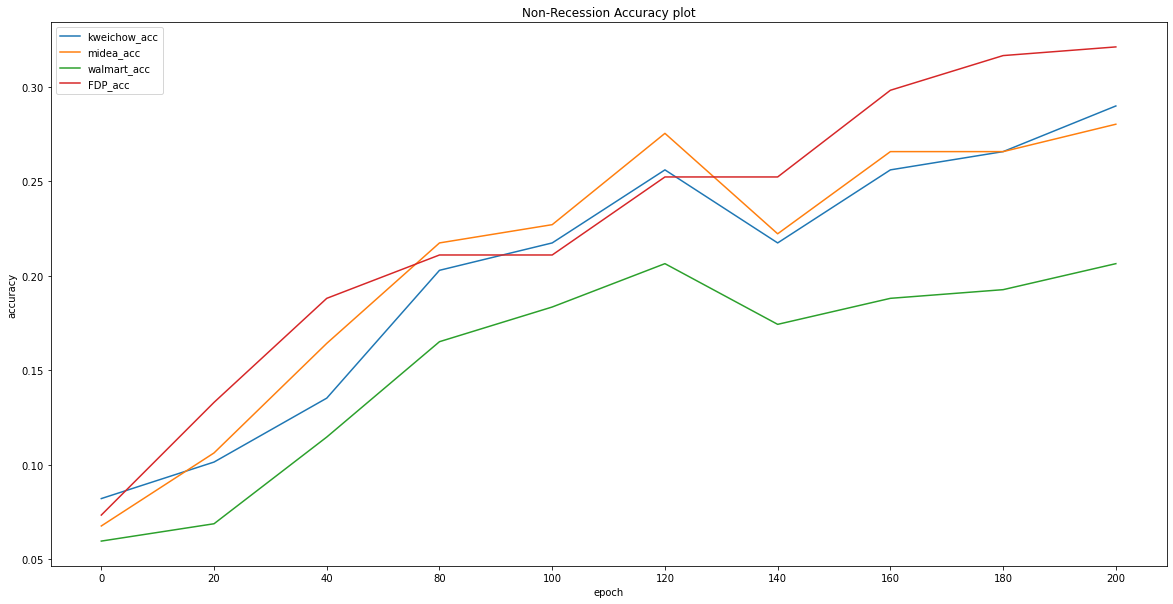

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

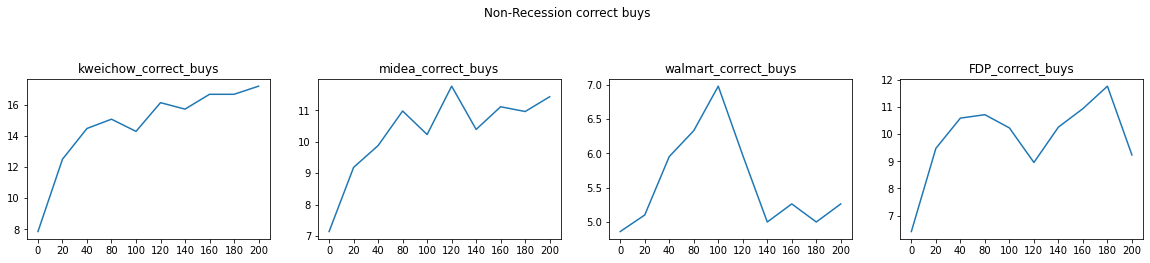

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")


Text(0.5, 1.0, 'FDP_correct_sells')

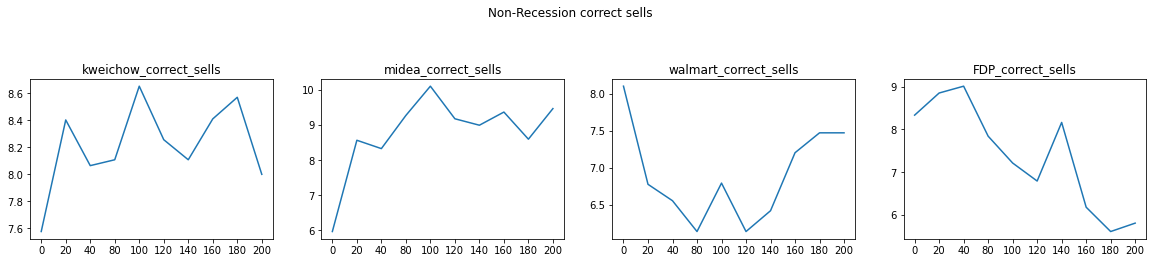

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

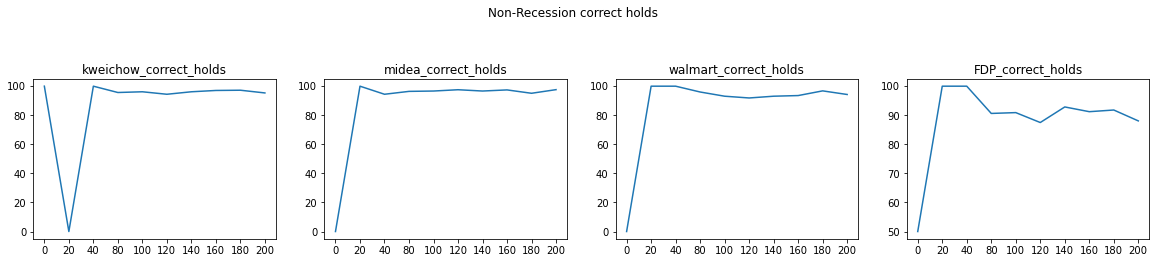

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

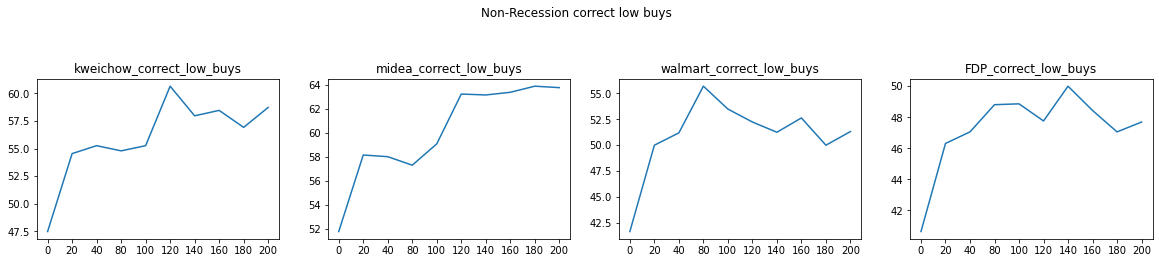

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

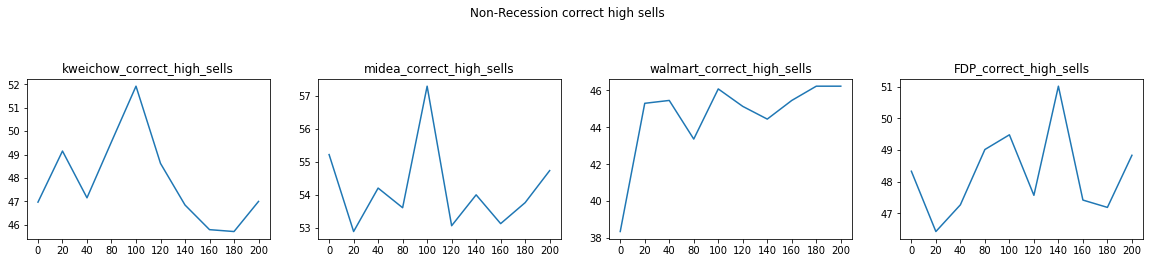

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

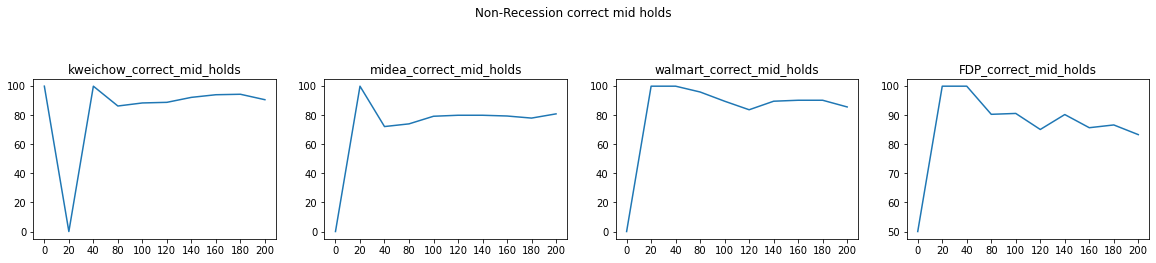

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

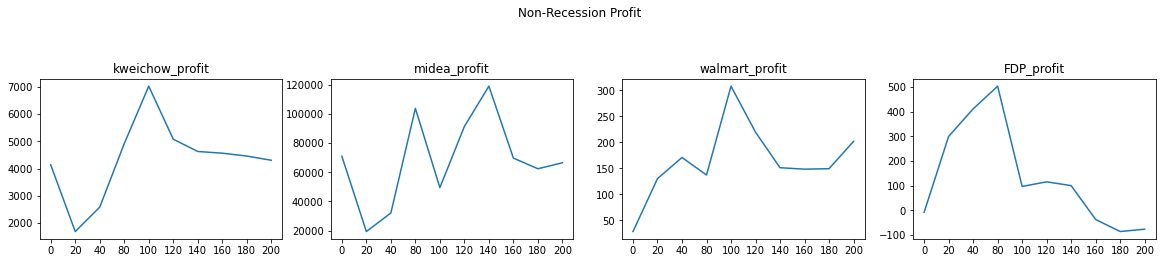

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [31]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


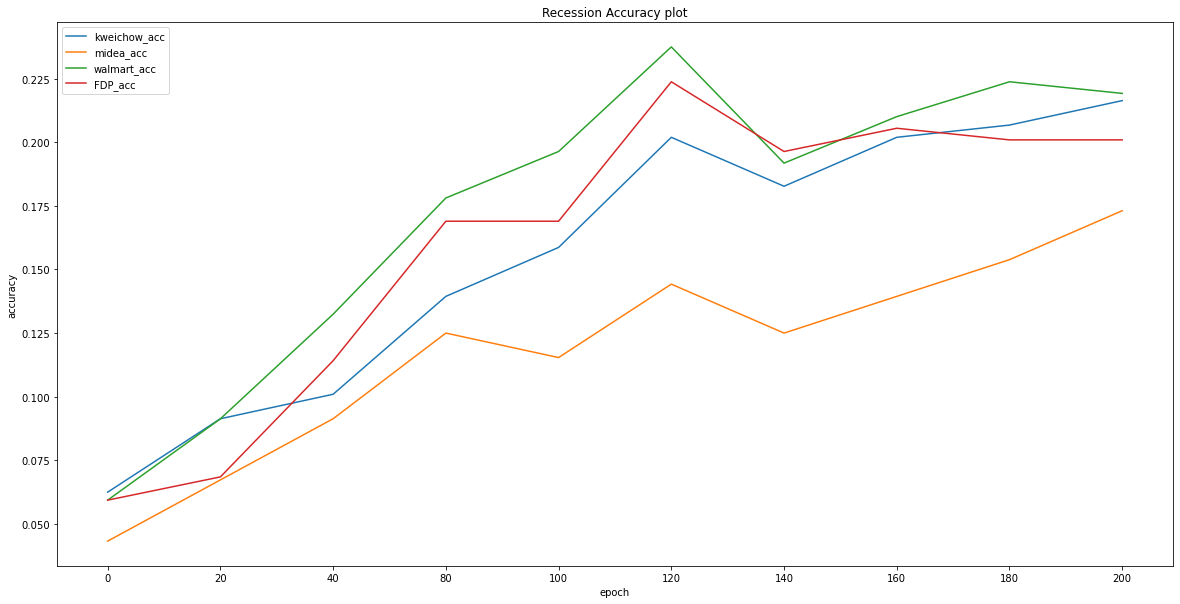

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

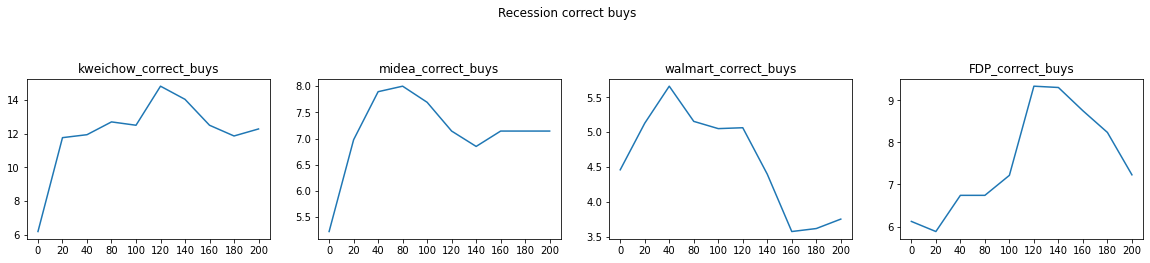

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

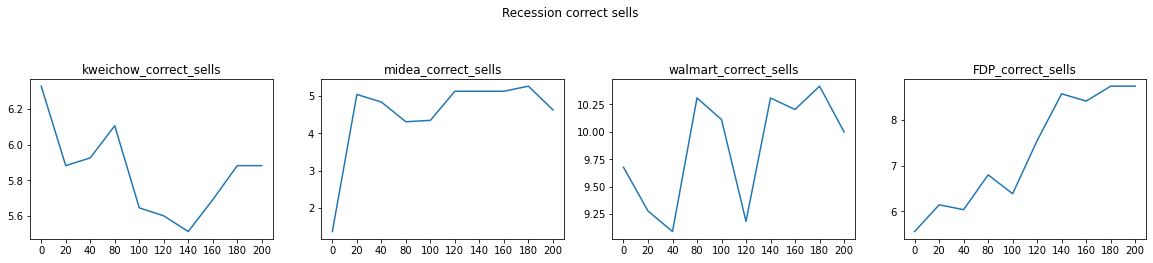

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

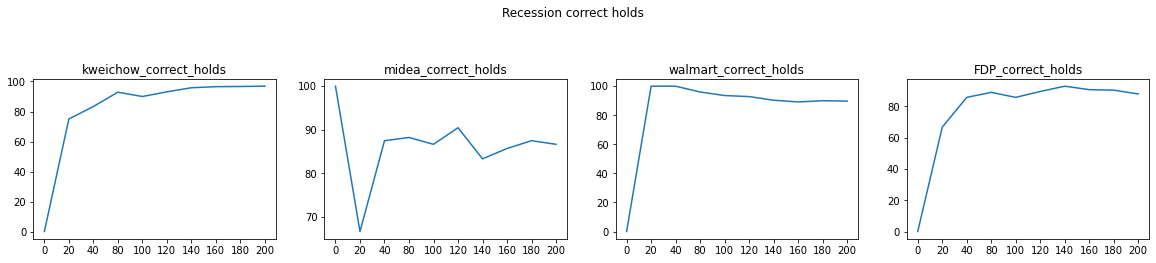

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

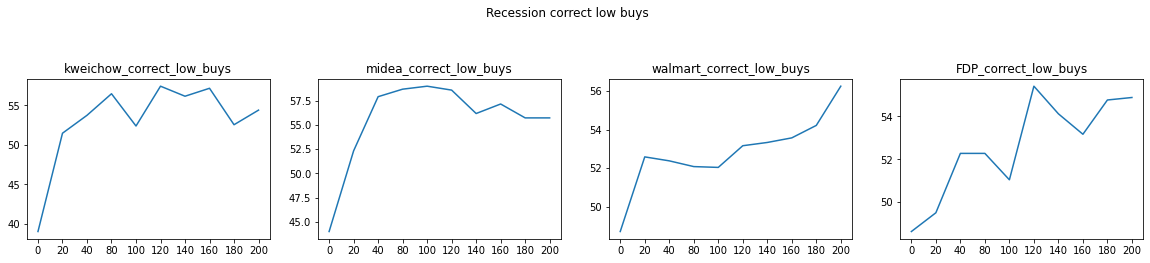

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

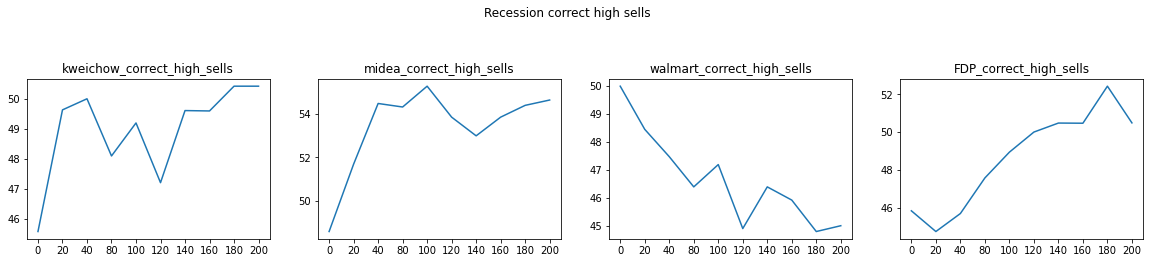

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

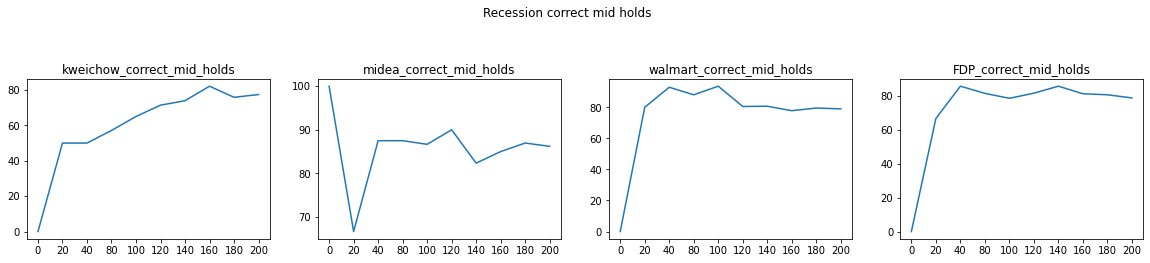

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

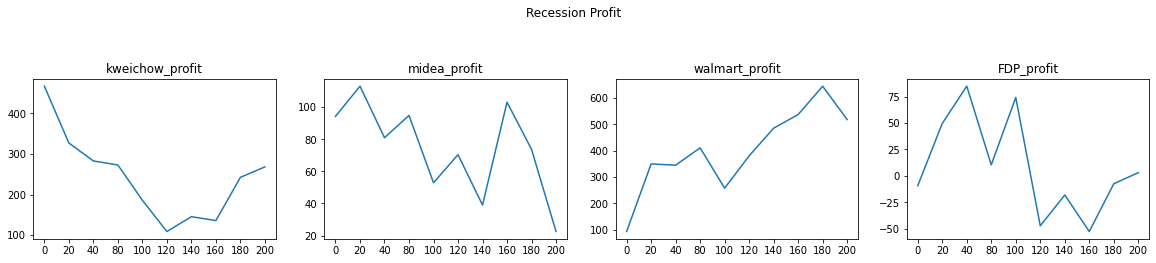

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")